In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm

In [49]:
pd.set_option('display.max_rows', 10)
plt.style.use('ggplot')

In [50]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
PATH = 'drive/MyDrive/Colab Notebooks/Yabloko Test task'

In [362]:
items = pd.read_csv(PATH+'/items.csv', ';', encoding = 'cp1251')
subm = pd.read_csv(PATH+'/test_submission.csv', ';', encoding = 'cp1251')
stock = pd.read_csv(PATH+'/stock.csv', encoding = 'utf-8')
sales = pd.read_csv(PATH+'/sales_train.csv', encoding = 'utf-8')

In [363]:
sales.date = pd.to_datetime(sales.date)

In [364]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99814 entries, 0 to 99813
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            99814 non-null  datetime64[ns]
 1   Month           99814 non-null  int64         
 2   Year            99814 non-null  int64         
 3   date_block_num  99814 non-null  int64         
 4   week            99814 non-null  int64         
 5   shop_id         99814 non-null  int64         
 6   item_id         99814 non-null  int64         
 7   brand_id        99814 non-null  int64         
 8   item_cnt_day    99814 non-null  int64         
 9   item_price      99814 non-null  int64         
 10  discamount      99814 non-null  int64         
 11  promo           99814 non-null  int64         
 12  size_disc       99814 non-null  int64         
 13  promo_time      99814 non-null  int64         
 14  spec_promo      99814 non-null  int64         
dtypes:

In [365]:
sales.head()

,date,Month,Year,date_block_num,week,shop_id,item_id,brand_id,item_cnt_day,item_price,discamount,promo,size_disc,promo_time,spec_promo
0,2018-01-01,1,2018,0,1,111,35852544067,10013,1,265,0,0,0,0,0
1,2018-01-01,1,2018,0,1,111,15793344028,10021,1,228,0,0,0,0,0
2,2018-01-01,1,2018,0,1,111,8221024002,10021,1,425,0,0,0,0,0
3,2018-01-01,1,2018,0,1,111,20221376004,10013,1,139,0,0,0,0,0
4,2018-01-01,1,2018,0,1,111,20221040001,10013,1,135,0,0,0,0,0


In [366]:
print(sales['brand_id'].value_counts(), end = '\n\n')
print(sales['shop_id'].value_counts(), end = '\n\n')
print('len item_id', len(sales.item_id.unique()))

10021    59140
10013    40674
Name: brand_id, dtype: int64

111    39314
110    31233
128    29267
Name: shop_id, dtype: int64

len item_id 1399


In [367]:
stock.head()

,store,month,days with 0 balance,year,itemid
0,128,9,3,2018,15799504008
1,111,9,2,2018,15816752002
2,128,12,1,2018,35865312103
3,111,12,2,2018,16924544029
4,111,1,1,2018,15801296004


In [368]:
items.head()

,item_id,brand_id,item_category_id,item_category
0,20224176006,10013,444,Макияж
1,20221040001,10013,444,Макияж
2,20221376004,10013,444,Макияж
3,15793344028,10021,444,Макияж
4,35852544052,10013,444,Макияж


In [369]:
items.item_category.value_counts()

Макияж              927
Уход                372
Парфюмерия           64
Уход за волосами      4
Name: item_category, dtype: int64

In [370]:
# число дней в датасете
sales.date.max()-sales.date.min()

Timedelta('820 days 00:00:00')

# Предварительные рассуждения

Имеем задачу прогнозирования временных рядов. Для каждой пары товар-магазин имеется свой ряд.
Прежде, чем приступать к разработке решения, я изучил практику решения схожих задач.

Предсказания буду строить отдельно по каждой паре товар-магазин на каждый день марта 2020. В модели не будет требоваться предсказание целых чисел, поскольку в конечном итоге нас интересует сумма продаж за месяц.

Для этого нужно дополнить ряды данными по продажам за каждый день(т.е. нулями в дни, о которых нет записей), чтобы получить полноценные временные ряды.

Оценим количество ненулевых дней для каждого продукта, т.е. дней когда были продажи.

In [371]:
item_ids = []

item_group = sales.groupby(['item_id', 'date'])['item_cnt_day'].sum()

for item in sales.item_id.unique():
    item_ids.append(len(item_group[item]))

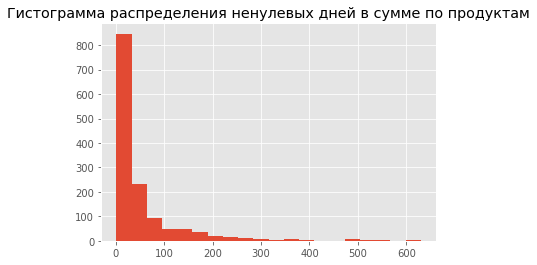

In [372]:
plt.hist(item_ids, bins = 20);
plt.title('Гистограмма распределения ненулевых дней в сумме по продуктам');

Отсюда видно, что для большинства продуктов количество ненулевых дней мало. Ряды сильно разрежены. Это значит, что мединна значений временного ряда по большинству продуктов будет нулевой. В такой ситуации стоит использовать MSE(RMSE), т.к. MAE будет отдавать предпочтение моделям дающим околонулевые предсказания - хотелось бы этого избежать

Для оценки качества такой задачи разработана метрика WRMSSE (Weighted Root Mean Squared Scaled Error)

$RMSSE = \sqrt{\frac{1}{h}*\frac{\sum_{t=n+1}^{n+h} {(Y_{t} - \hat{Y_{t}})}^{2}}
{\frac{1}{n-1}\sum_{t=2}^{n} {(Y_{t} - Y_{t-1})}^{2}}}$ ,

- $Y_{t}$ - количество продаж в день t
- $\hat{Y_{t}}$ - предсказание в день t
- h = 31 горизонт предсказания (число дней предсказания, т.е. в марте 2020)
- n = 820 - 31 = 789 число дней в train датасете
- знаменатель вычисляется только для периодов активной продажи, т.е. для периодов, следующих за первым ненулевым наблюдением в оцениваемом ряде

После вычисления RMSSE для каждого ряда, вычисляем:

$WRMSSE = \sum_{i=1}^{} {w}_{i}*{RMSSE}_{i}$ ,

- где вес ${w}_{i}$ каждого ряда вычисляется как объем продаж продукта в рублях за последний 31 день

Что она дает:
- оценка разных временных рядов не зависит от масштаба каждого ряда
- безопасные вычисления метрики, поскольку знаменатель считается для значений с момента, когда они становятся ненулевыми
- веса сильнее штрафуют ошибки по рядам, в которые было больше продаж в последнее время

В условиях ограниченного времени на тестовое задание, я не буду реализовывать данную метрику. Но для улучшения качества при наличии времени, ее вполне стоило бы взять во внимание.

Сейчас же использую обычную RMSE по предсказаниям каждого временного ряда и далее усредненную по всем оцененным рядам

# 0. Очистка и предобработка данных

In [373]:
# уберем некорректное значение
items[items.item_id == '#Н/Д']

,item_id,brand_id,item_category_id,item_category
535,#Н/Д,10013,444,Макияж


In [374]:
items = items.drop([535], axis = 0)
items.item_id = items.item_id.astype(int)

### stock preprocessing
В датафрейм остатков на складе добавим признак порядкового номера месяца, для последующих соединений баз

In [375]:
stock['date_block_num'] = stock.month-1 + 12*(stock.year-2018)
stock

,store,month,days with 0 balance,year,itemid,date_block_num
0,128,9,3,2018,15799504008,8
1,111,9,2,2018,15816752002,8
2,128,12,1,2018,35865312103,11
3,111,12,2,2018,16924544029,11
4,111,1,1,2018,15801296004,0
...,...,...,...,...,...,...
17673,111,2,2,2020,15819664007,25
17674,128,2,2,2020,16925552011,25
17675,128,1,16,2020,15818992011,24
17676,111,2,2,2020,16924096055,25


In [376]:
# в датафрейме stock присутствуют противоречивые значения.
# здесь, например, одному месяцу соответствуют 2 разные значения days with 0 balance

stock[(stock.itemid == item_id) & (stock.store == shop_id)]

,store,month,days with 0 balance,year,itemid,date_block_num


In [377]:
# найдем все такие записи

stock_groups = stock.groupby(['store', 'itemid', 'date_block_num'])['days with 0 balance'].count()
stock_groups[stock_groups>1].index

MultiIndex([(110,  8221024002,  8),
            (110,  8221024002, 11),
            (110, 15792112003, 15),
            (110, 15792112003, 21),
            (110, 15792224009, 14),
            (110, 15792336004,  3),
            (110, 15792336004, 14),
            (110, 15792336004, 15),
            (110, 15792336006,  2),
            (110, 15792336006, 19),
            ...
            (128, 90036912007, 13),
            (128, 90036912012,  8),
            (128, 90036912012, 11),
            (128, 90036912012, 12),
            (128, 90036912012, 19),
            (128, 90036912012, 21),
            (128, 90036912013,  8),
            (128, 90036912013, 13),
            (128, 90036912013, 19),
            (128, 90036912013, 20)],
           names=['store', 'itemid', 'date_block_num'], length=3080)

3080 спорных групп значений... Пока не очень понятно, что с ними делать.
Надо будет оценить как повлияют на результат разные подходы - взять среднее значение по спорному месяцу, среднее за все время по товару и магазину, минимальное, максимальное, удалить спорные значения. Подготовим соответствующую функцию, которая обрабатывает stock

In [378]:
def get_stock(mode = 'month_mean'):

    if mode == 'month_mean': 
        return stock.groupby(['store', 'itemid', 'date_block_num'])['days with 0 balance'].mean().reset_index()
    
    elif mode == 'item_mean': pass
    
    elif mode == 'del': 
        list_index = []
        for store, item, date_block_num in stock_groups[stock_groups>1].index:
            list_index.extend(stock[(stock.itemid == item) & \
                                (stock.store == store) & (stock.date_block_num == date_block_num)].index.to_list())    
        return stock.drop(list_index, axis = 0).reset_index()
    
    else: raise ValueError('noSuchMode: use month_mean, item_mean or del')

In [379]:
get_stock('month_mean')

,store,itemid,date_block_num,days with 0 balance
0,110,8221024002,1,3.0
1,110,8221024002,3,1.0
2,110,8221024002,5,1.0
3,110,8221024002,8,2.5
4,110,8221024002,10,1.0
...,...,...,...,...
14593,128,90037584002,15,1.0
14594,128,90037584002,17,1.0
14595,128,90037584002,20,1.0
14596,128,90037584002,22,1.0


### Соберу датафрейм calendar, для формирования полноценных временных рядов далее

In [380]:
calendar = sales.groupby(['date', 'Month', 'Year', 'date_block_num', 'week'])\
                ['item_price'].mean()
calendar = calendar.reset_index()[['date', 'Month', 'Year', 'date_block_num', 'week']]
calendar.index = calendar.date
calendar.drop('date', axis =1, inplace = True)

Добавлю несколько календарных признаков:

- порядковый номер дня (1-820)
- номер дня недели (0-6)
- номер дня года (1-365)
- бинарный признак праздничного дня

In [381]:
calendar['day'] = list(range(1, 821))
calendar['day_of_week'] = calendar.index.weekday
calendar['day_of_year'] = calendar.index.dayofyear
calendar['holidays'] = [0]*820

In [382]:
# Праздничные выходные в 2018 году

#     30 декабря — 8 января (10) Новогодние каникулы 2018
#     23 февраля — 25 февраля (3) День защитника Отечества
#     8 марта — 11 марта (4) Международный женский день
#     29 апреля — 2 мая (4) Праздник весны и труда
#     9 мая (1) День Победы
#     10 июня — 12 июня (3) День России
#     3 ноября — 5 ноября (3) День народного единства

calendar.loc['2018-01-01':'2018-01-08', 'holidays'] = 1
calendar.loc['2018-02-23':'2018-02-25', 'holidays'] = 1
calendar.loc['2018-03-08':'2018-03-11', 'holidays'] = 1
calendar.loc['2018-04-29':'2018-05-02', 'holidays'] = 1
calendar.loc['2018-05-09', 'holidays'] = 1
calendar.loc['2018-06-10':'2018-06-12', 'holidays'] = 1
calendar.loc['2018-11-03':'2018-11-05', 'holidays'] = 1

# Праздничные выходные в 2019 году

#     30 декабря — 8 января (10) Новогодние каникулы 2019
#     23 февраля (1) День защитника Отечества
#     8 марта — 10 марта (3) Международный женский день
#     1 мая — 5 мая (5) Праздник весны и труда
#     9 мая — 12 мая (4) День Победы
#     12 июня (1) День России
#     2 ноября — 4 ноября (3) День народного единства

calendar.loc['2018-12-30':'2019-01-08', 'holidays'] = 1
calendar.loc['2019-02-23', 'holidays'] = 1
calendar.loc['2019-03-08':'2019-03-10', 'holidays'] = 1
calendar.loc['2019-05-01':'2019-05-05', 'holidays'] = 1
calendar.loc['2019-05-09':'2019-05-12', 'holidays'] = 1
calendar.loc['2019-06-12', 'holidays'] = 1
calendar.loc['2019-11-02':'2019-11-04', 'holidays'] = 1

# Праздничные выходные в 2020 году

#     1 января — 8 января (8) Новогодние каникулы 2020
#     22 февраля — 24 февраля (3) День защитника Отечества
#     7 марта — 9 марта (3) Международный женский день
#     28 марта — 5 апреля (9) Выходные в связи с карантином COVID-19

calendar.loc['2020-01-01':'2020-01-08', 'holidays'] = 1
calendar.loc['2020-02-22':'2020-02-24', 'holidays'] = 1
calendar.loc['2020-03-07':'2020-03-09', 'holidays'] = 1
calendar.loc['2020-03-28':'2020-03-31', 'holidays'] = 1

In [383]:
calendar

,Month,Year,date_block_num,week,day,day_of_week,day_of_year,holidays
date,,,,,,,,
2018-01-01,1,2018,0,1,1,0,1,1
2018-01-02,1,2018,0,1,2,1,2,1
2018-01-03,1,2018,0,1,3,2,3,1
2018-01-04,1,2018,0,1,4,3,4,1
2018-01-05,1,2018,0,1,5,4,5,1
...,...,...,...,...,...,...,...,...
2020-03-26,3,2020,26,119,816,3,86,0
2020-03-27,3,2020,26,119,817,4,87,0
2020-03-29,3,2020,26,119,818,6,89,1


### sales preprocessing

Заметил, что в данных присутствуют отрицательные значения скидок и количества проданных товаров.
Эти данные лишены смысла и стоит их сразу удалить
(их можно было бы интерпретировать как возвраты, но точно мне это неизвестно и количество таких записей невелико. Проще их удалить, чтобы не портить предсказания, хотя при наличии времени можно было бы посмотреть как эти данные влияют на модель)

In [384]:
sales[(sales.item_cnt_day < 0) | (sales.discamount < 0)]

,date,Month,Year,date_block_num,week,shop_id,item_id,brand_id,item_cnt_day,item_price,discamount,promo,size_disc,promo_time,spec_promo
1967,2018-01-27,1,2018,0,4,111,16923312054,10021,-1,754,302,1,40,2,0
2107,2018-01-28,1,2018,0,4,111,16923312060,10021,-1,587,235,1,40,2,0
2382,2018-01-30,1,2018,0,5,111,20221936008,10013,-1,187,0,0,0,0,0
2460,2018-01-31,1,2018,0,5,110,15850800009,10013,-1,283,0,0,0,0,0
3138,2018-02-10,2,2018,1,6,128,20220592002,10013,-1,182,-73,1,40,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94035,2020-02-24,2,2020,25,115,111,17026912001,10013,-1,501,0,0,0,0,0
94107,2020-02-24,2,2020,25,115,111,17027472013,10013,-1,392,0,0,0,0,0
94638,2020-02-28,2,2020,25,115,111,15803088002,10021,-1,188,94,1,50,3,0
95763,2020-03-05,3,2020,26,116,110,35852544087,10013,0,692,-308,1,40,3,0


In [385]:
sales = sales[(sales.item_cnt_day >= 0) & (sales.discamount >= 0)]

Обратил внимание на то, что чаще одному дню соответствует одна запись, но иногда бывает и несколько. 
В таком случае группируем продажи по дням следующим образом:

- Данные по количеству проданных товаров за день - сумма за день
- Цена, сумма скидки, количество дней акции - среднее
- Размер скидки в % пересчитать из найденных сумм и средних
- А вот у бинарных признаков взять среднее с округлением.

Теоретически в рамках одного дня значение бинарного признака не должно изменяться. Но если где-то такое встретится - будем считать по значениям, которые встретились чаще

**Соберу отдельный датасет для одной пары товар-магазин**, чтобы изучить данные и отработать подходы на частном случае

In [386]:
item_id = 15793344028
shop_id = 111

# сгруппируем и преобразуем данные так, чтобы на каждый день была не более, чем одна запись

item_cnt_day = sales[(sales.item_id == item_id) & (sales.shop_id == shop_id)]\
        .groupby(['date', 'shop_id', 'item_id', 'brand_id'])[['item_cnt_day']].agg(['sum'])

item_cnt_day = item_cnt_day.reset_index()
item_cnt_day.columns = ['date','shop_id','item_id','brand_id','item_cnt_day']
item_cnt_day.index = item_cnt_day.date
item_cnt_day.drop('date', axis =1, inplace = True)

price = sales[(sales.item_id == item_id) & (sales.shop_id == shop_id)].groupby(['date'])\
        [['item_price', 'discamount', 'promo_time']].agg(['mean'])
price.columns = ['item_price', 'discamount', 'promo_time']

promo_binary = sales[(sales.item_id == item_id) & (sales.shop_id == shop_id)].groupby(['date'])\
        [['promo', 'spec_promo']].agg(['mean'])
promo_binary.columns = ['promo', 'spec_promo']
promo_binary = np.round(promo_binary)

item_sales = pd.concat([item_cnt_day, price, promo_binary], axis = 1)
item_sales['size_disc'] = list(map(int, item_sales.discamount/item_sales.item_price*100))

brand_id = item_cnt_day.brand_id[0]

item_sales.head()

,shop_id,item_id,brand_id,item_cnt_day,item_price,discamount,promo_time,promo,spec_promo,size_disc
date,,,,,,,,,,
2018-01-01,111,15793344028,10021,1,228,0,0,0,0,0
2018-02-07,111,15793344028,10021,1,228,0,0,0,0,0
2018-02-18,111,15793344028,10021,1,228,0,0,0,0,0
2018-04-13,111,15793344028,10021,1,228,0,0,0,0,0
2018-04-27,111,15793344028,10021,1,228,91,2,1,0,39


In [387]:
# соединяю датафрейм по товару с датафреймом календаря, чтобы получить полноценный временной ряд,
# со значениями в каждый момент времени за период

item_sales_ts = calendar.merge(item_sales, how = 'left', on = 'date')
item_sales_ts.loc[:, 'shop_id'] = shop_id
item_sales_ts.loc[:, 'item_id'] = item_id
item_sales_ts.loc[:, 'brand_id'] = brand_id
item_sales_ts.fillna(0, inplace = True)

item_sales_ts.head()

,Month,Year,date_block_num,week,day,day_of_week,day_of_year,holidays,shop_id,item_id,brand_id,item_cnt_day,item_price,discamount,promo_time,promo,spec_promo,size_disc
date,,,,,,,,,,,,,,,,,,
2018-01-01,1,2018,0,1,1,0,1,1,111,15793344028,10021,1.0,228.0,0.0,0.0,0.0,0.0,0.0
2018-01-02,1,2018,0,1,2,1,2,1,111,15793344028,10021,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-03,1,2018,0,1,3,2,3,1,111,15793344028,10021,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-04,1,2018,0,1,4,3,4,1,111,15793344028,10021,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-05,1,2018,0,1,5,4,5,1,111,15793344028,10021,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [388]:
# добавим данные по остаткам на складе

# пока берем средние значение остатков по товару за месяц
stock_mean = get_stock('month_mean')

item_stock = stock_mean[(stock_mean.itemid == item_id) & (stock_mean.store == shop_id)]\
                                                        [['date_block_num','days with 0 balance']]
item_sales_ts = item_sales_ts.merge(item_stock, how = 'left', on = 'date_block_num')
item_sales_ts.index = calendar.index
item_sales_ts['days with 0 balance'].fillna(0, inplace = True)

item_sales_ts

,Month,Year,date_block_num,week,day,day_of_week,day_of_year,holidays,shop_id,item_id,brand_id,item_cnt_day,item_price,discamount,promo_time,promo,spec_promo,size_disc,days with 0 balance
date,,,,,,,,,,,,,,,,,,,
2018-01-01,1,2018,0,1,1,0,1,1,111,15793344028,10021,1.0,228.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-02,1,2018,0,1,2,1,2,1,111,15793344028,10021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-03,1,2018,0,1,3,2,3,1,111,15793344028,10021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-04,1,2018,0,1,4,3,4,1,111,15793344028,10021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-05,1,2018,0,1,5,4,5,1,111,15793344028,10021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-26,3,2020,26,119,816,3,86,0,111,15793344028,10021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-27,3,2020,26,119,817,4,87,0,111,15793344028,10021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-29,3,2020,26,119,818,6,89,1,111,15793344028,10021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Соберем все в одну функцию

In [389]:
stock_ = get_stock('month_mean')

def get_tseries(item_id, shop_id):
    
    # сгруппируем и преобразуем данные так, чтобы на каждый день была не более, чем одна запись

    item_cnt_day = sales[(sales.item_id == item_id) & (sales.shop_id == shop_id)]\
            .groupby(['date', 'shop_id', 'item_id', 'brand_id'])[['item_cnt_day']].agg(['sum'])

    if len(item_cnt_day) == 0:
        return None
    
    item_cnt_day = item_cnt_day.reset_index()
    item_cnt_day.columns = ['date','shop_id','item_id','brand_id','item_cnt_day']
    item_cnt_day.index = item_cnt_day.date
    item_cnt_day.drop('date', axis =1, inplace = True)

    price = sales[(sales.item_id == item_id) & (sales.shop_id == shop_id)].groupby(['date'])\
            [['item_price', 'discamount', 'promo_time']].agg(['mean'])
    price.columns = ['item_price', 'discamount', 'promo_time']

    promo_binary = sales[(sales.item_id == item_id) & (sales.shop_id == shop_id)].groupby(['date'])\
            [['promo', 'spec_promo']].agg(['mean'])
    promo_binary.columns = ['promo', 'spec_promo']
    promo_binary = np.round(promo_binary)

    item_sales = pd.concat([item_cnt_day, price, promo_binary], axis = 1)
    item_sales['size_disc'] = list(map(int, item_sales.discamount/item_sales.item_price*100))

    brand_id = item_cnt_day.brand_id[0]

    # соединяю датафрейм по товару с датафреймом календаря, чтобы получить полноценный временной ряд,
    # со значениями в каждый момент времени за период

    item_sales_ts = calendar.merge(item_sales, how = 'left', on = 'date')
    item_sales_ts.loc[:, 'shop_id'] = shop_id
    item_sales_ts.loc[:, 'item_id'] = item_id
    item_sales_ts.loc[:, 'brand_id'] = brand_id
    item_sales_ts.fillna(0, inplace = True)

    # добавим данные по остаткам на складе

    item_stock = stock_mean[(stock_.itemid == item_id) & (stock_.store == shop_id)]\
                                                            [['date_block_num','days with 0 balance']]
    item_sales_ts = item_sales_ts.merge(item_stock, how = 'left', on = 'date_block_num')
    item_sales_ts.index = calendar.index
    item_sales_ts['days with 0 balance'].fillna(0, inplace = True)
    
    return item_sales_ts

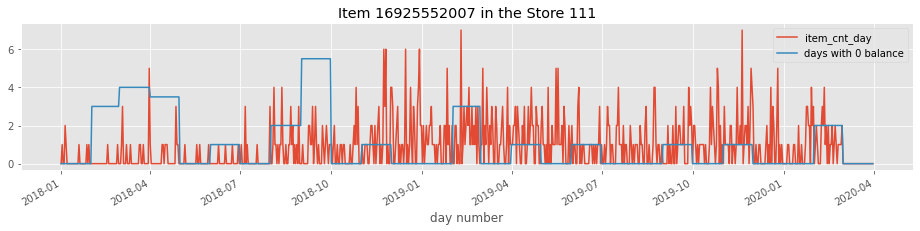

In [390]:
item_series = get_tseries(item_id = 16925552007, shop_id = 111)

plt.figure(figsize = (16,3))
item_series.item_cnt_day.plot()
item_series['days with 0 balance'].plot()

plt.title('Item {} in the Store {}'.format(item_series.item_id[0], item_series.shop_id[0]))
plt.legend();
plt.xlabel('day number');

# 1. EDA

Для исследования данных и поиска рабочих подходов я выбрал 3 мало похожих друг на друга ряда:

In [403]:
shop_id = 111
item_ids = [17024112016, 15795248015, 16925552007]

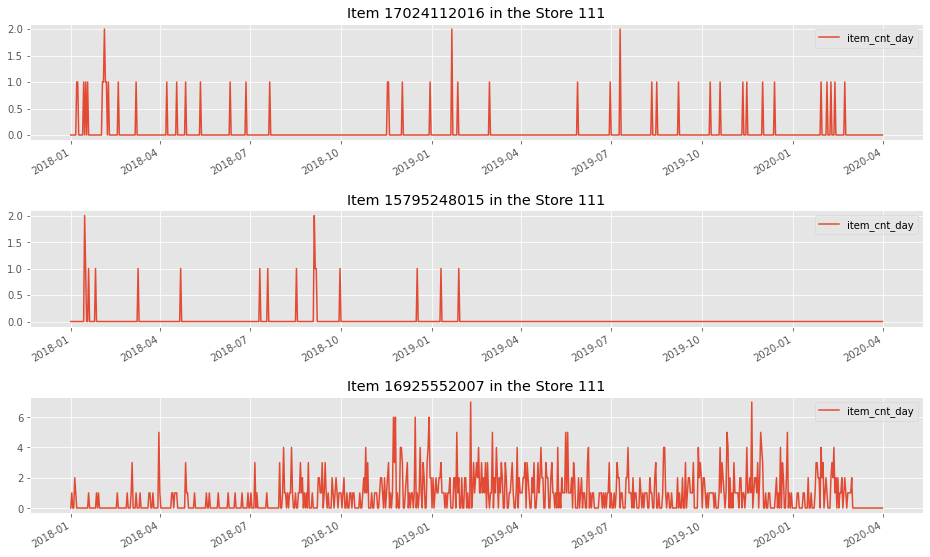

In [392]:
plt.figure(figsize = (16,10))
item_series = []

for i, item in enumerate(item_ids):
    item_series.append(get_tseries(item_id = item, shop_id = shop_id))

    plt.subplot(3,1,i+1)
    item_series[-1].item_cnt_day.plot()

    plt.title('Item {} in the Store {}'.format(item_series[-1].item_id[0], item_series[-1].shop_id[0]))
    plt.legend();
    plt.xlabel('');
    
plt.subplots_adjust(hspace=0.6)

- Первый ряд - сильно разрежен, но какие то продажи должен показать
- Второй ряд - также разрежен, но продажи продукта очевидно прекратились. Предсказание скорее всего должно быть нулевым или около того
- Третий ряд - один из наиболее продаваемых продуктов

Все продукты беру по одному магазину - 111

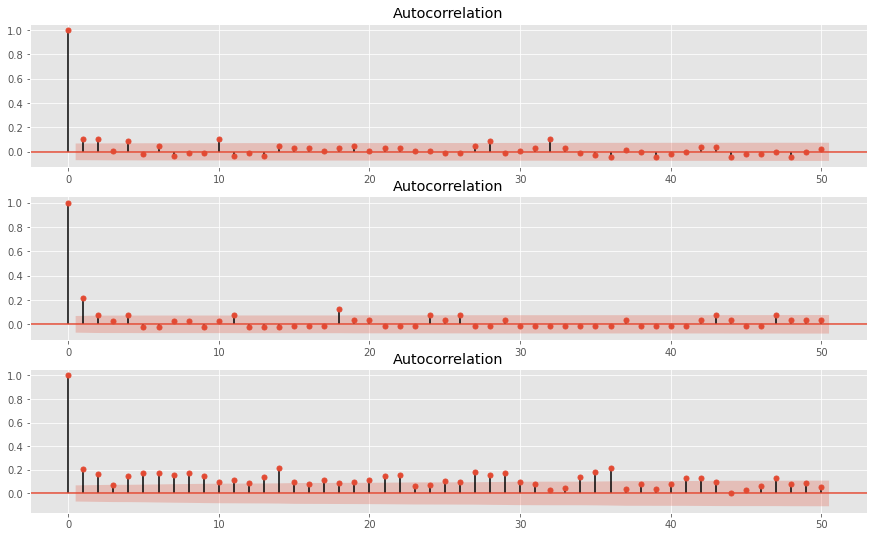

In [393]:
# Автокорреляции

plt.figure(figsize=(15,9))

ax = plt.subplot(311)
sm.graphics.tsa.plot_acf(item_series[0].item_cnt_day, lags=50, ax=ax)

ax = plt.subplot(312)
sm.graphics.tsa.plot_acf(item_series[1].item_cnt_day, lags=50, ax=ax)

ax = plt.subplot(313)
sm.graphics.tsa.plot_acf(item_series[2].item_cnt_day, lags=50, ax=ax)

plt.show()

Чем больше продаж, тем сильнее видно значимые автокорреляции.

Однако, ряды сильно разрежены и стандартные методы обработки, вроде преобразований Бокса-Кокса или дифференцирования ряда, вряд ли что-то нам дадут - тем более в массовой обработке, когда ряды разрежены в разной степени и искать подходящий порядок дифференцирования каждого из 3000 рядов не представляется возможным.

Буду надеяться, порядковых признаков в calendar должно быть достаточно для того, чтобы уловить автокорреляционные зависимости (убедимся так ли это позже).
Также дополню их новыми признаками по данным продаж.

In [107]:
brands = sales.brand_id.unique()
shops = sales.shop_id.unique()

### Продажи

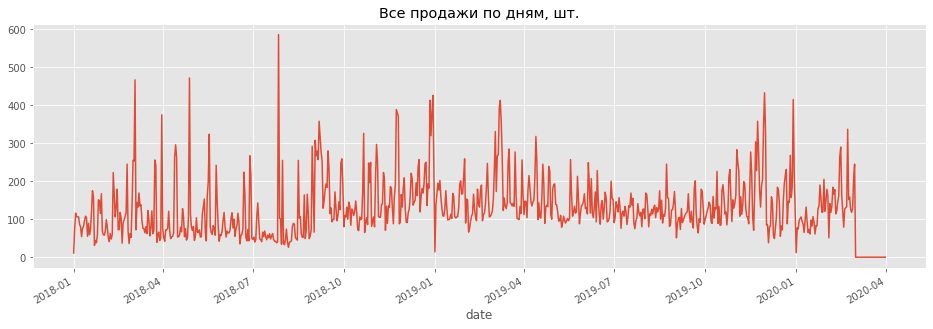

In [122]:
plt.figure(figsize = (16,5))
sales.groupby('date')['item_cnt_day'].sum().plot()
plt.title('Все продажи по дням, шт.');

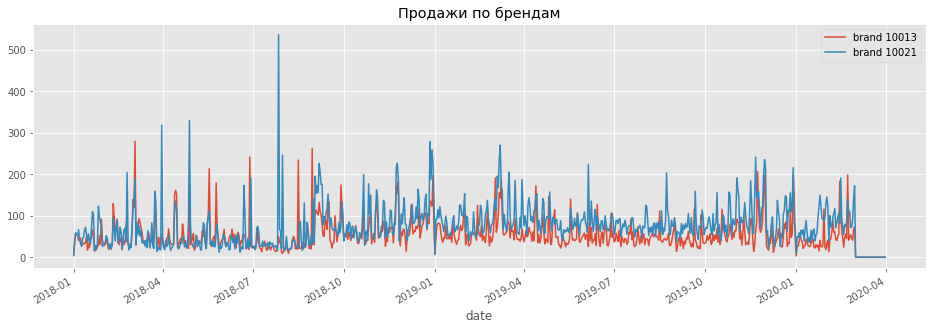

In [123]:
plt.figure(figsize = (16,5))

for brand in brands:
  sales[sales.brand_id == brand].groupby('date')['item_cnt_day'].sum().plot(label = 'brand {}'.format(brand))

plt.legend()
plt.title('Продажи по брендам');


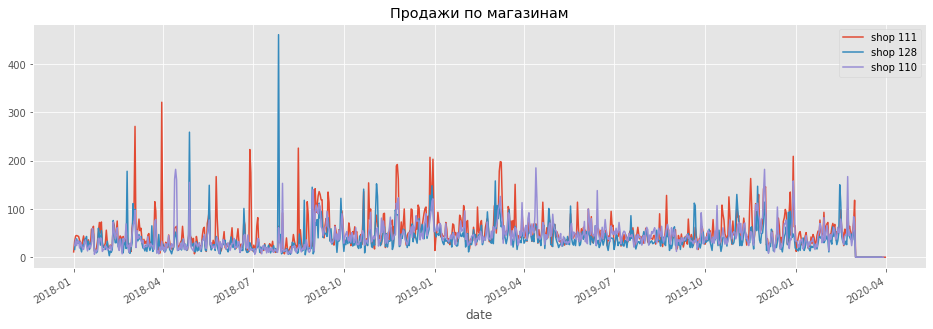

In [124]:
plt.figure(figsize = (16,5))

for shop in shops:
  sales[sales.shop_id == shop].groupby('date')['item_cnt_day'].sum().plot(label = 'shop {}'.format(shop))

plt.legend()
plt.title('Продажи по магазинам');


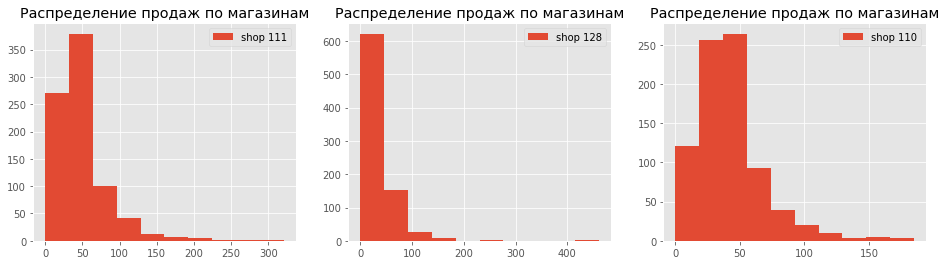

In [152]:
plt.figure(figsize = (16,4))

for i, shop in enumerate(shops):
    plt.subplot(1,3,i+1)
    sales[sales.shop_id == shop].groupby('date')['item_cnt_day'].sum().hist(label = 'shop {}'.format(shop))
    plt.legend()
    plt.title('Распределение продаж по магазинам')

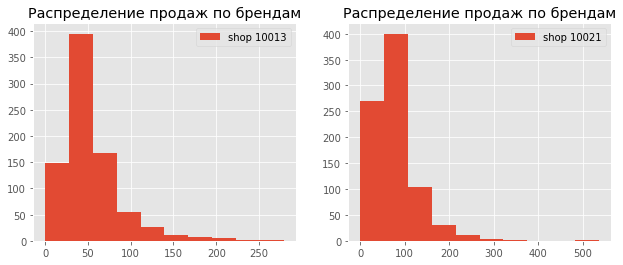

In [184]:
plt.figure(figsize = (16,4))

for i, brand in enumerate(brands):
    plt.subplot(1,3,i+1)
    sales[sales.brand_id == brand].groupby('date')['item_cnt_day'].sum().hist(label = 'shop {}'.format(brand))
    plt.legend()
    plt.title('Распределение продаж по брендам')

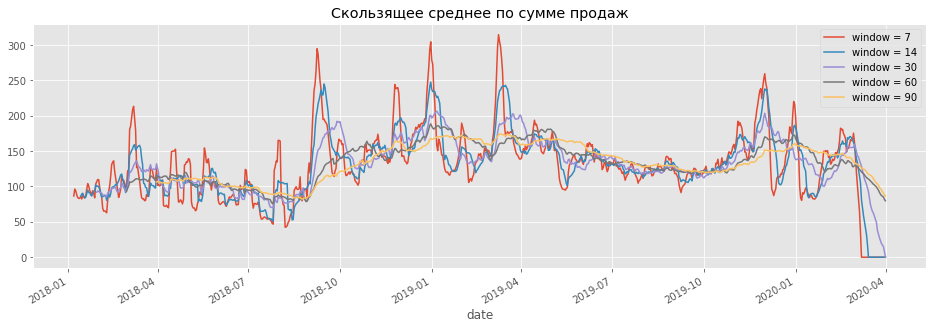

In [157]:
plt.figure(figsize = (16,5))
for window in [7,14,30,60,90]:
  sales.groupby('date')['item_cnt_day'].sum().rolling(window).mean().plot(label = 'window = {}'.format(window))
plt.title('Скользящее среднее по сумме продаж')
plt.legend();

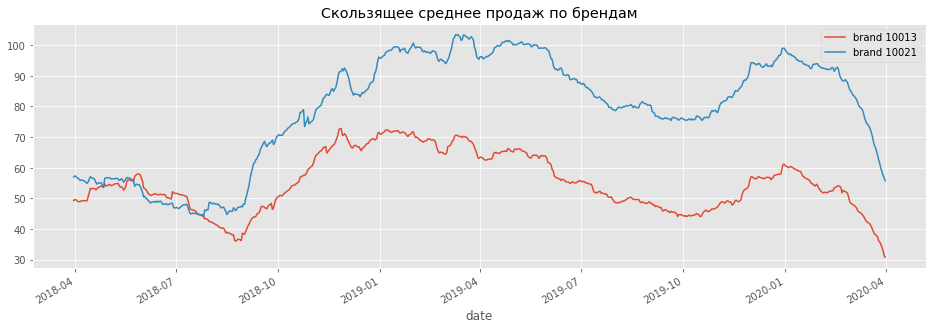

In [160]:
plt.figure(figsize = (16,5))
for brand in brands:
  sales[sales.brand_id == brand].groupby('date')['item_cnt_day'].sum().rolling(window).mean().plot(label = 'brand {}'.format(brand))

plt.title('Скользящее среднее продаж по брендам')
plt.legend();

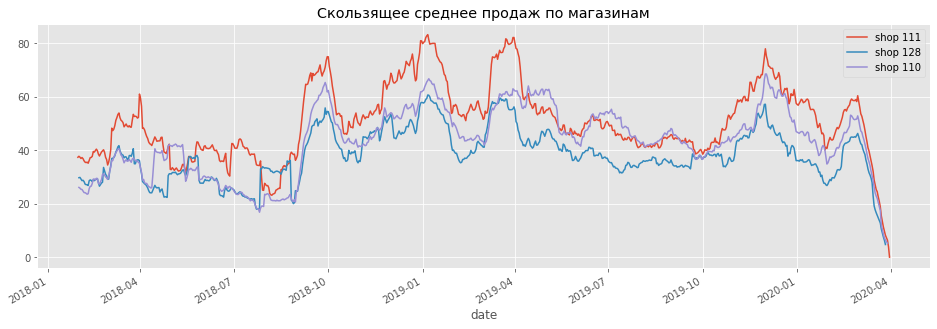

In [207]:
plt.figure(figsize = (16,5))
for shop in shops:
  sales[sales.shop_id == shop].groupby('date')['item_cnt_day'].sum().rolling(30).mean().plot(label = 'shop {}'.format(shop))

plt.title('Скользящее среднее продаж по магазинам')
plt.legend();

### Цены
Посмотрим, есть ли зависимости в средних ценах

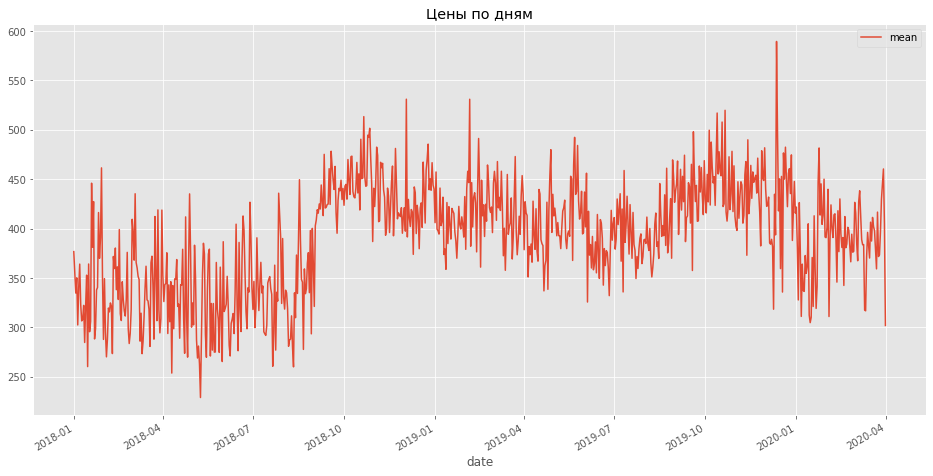

In [192]:
plt.figure(figsize = (16,8))
sales.groupby('date')['item_price'].mean().plot(label = 'mean')
plt.legend()
plt.title('Цены по дням');

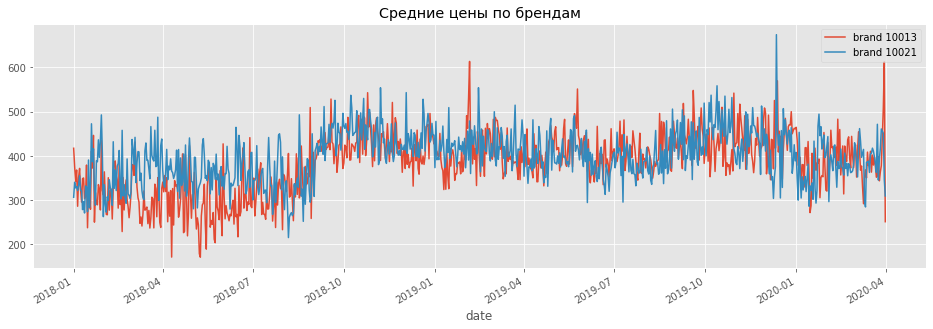

In [179]:
plt.figure(figsize = (16,5))

for brand in brands:
  sales[sales.brand_id == brand].groupby('date')['item_price'].mean().plot(label = 'brand {}'.format(brand))

plt.legend()
plt.title('Средние цены по брендам');


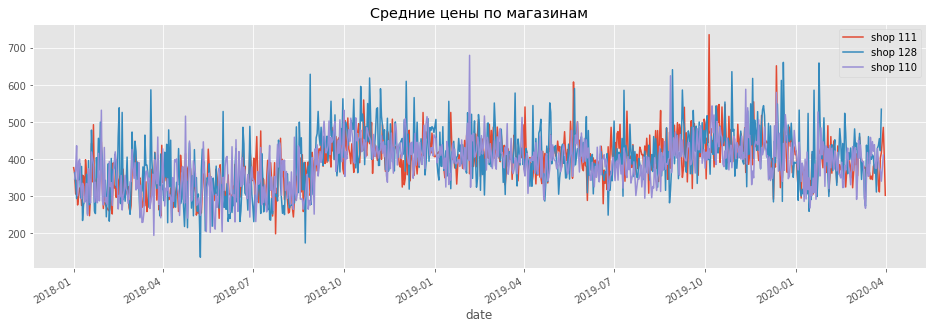

In [181]:
plt.figure(figsize = (16,5))

for shop in shops:
  sales[sales.shop_id == shop].groupby('date')['item_price'].mean().plot(label = 'shop {}'.format(shop))

plt.legend()
plt.title('Средние цены по магазинам');


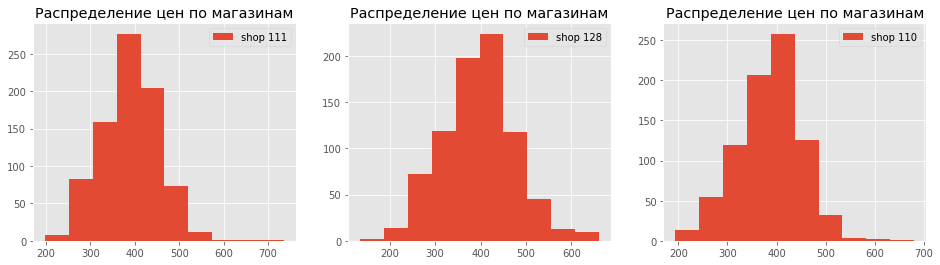

In [183]:
plt.figure(figsize = (16,4))

for i, shop in enumerate(shops):
    plt.subplot(1,3,i+1)
    sales[sales.shop_id == shop].groupby('date')['item_price'].mean().hist(label = 'shop {}'.format(shop))
    plt.legend()
    plt.title('Распределение цен по магазинам')

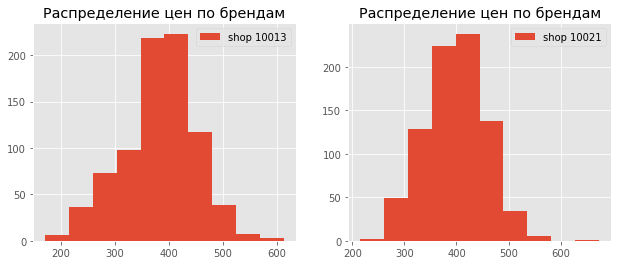

In [185]:
plt.figure(figsize = (16,4))

for i, brand in enumerate(brands):
    plt.subplot(1,3,i+1)
    sales[sales.brand_id == brand].groupby('date')['item_price'].mean().hist(label = 'shop {}'.format(brand))
    plt.legend()
    plt.title('Распределение цен по брендам')

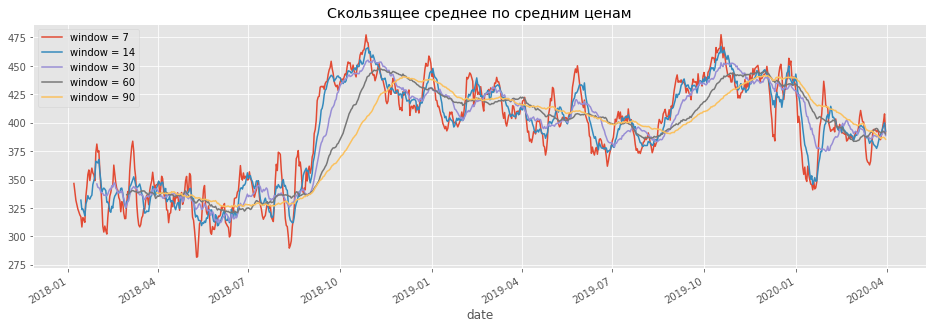

In [186]:
plt.figure(figsize = (16,5))
for window in [7,14,30,60,90]:
  sales.groupby('date')['item_price'].mean().rolling(window).mean().plot(label = 'window = {}'.format(window))
plt.title('Скользящее среднее по средним ценам')
plt.legend();

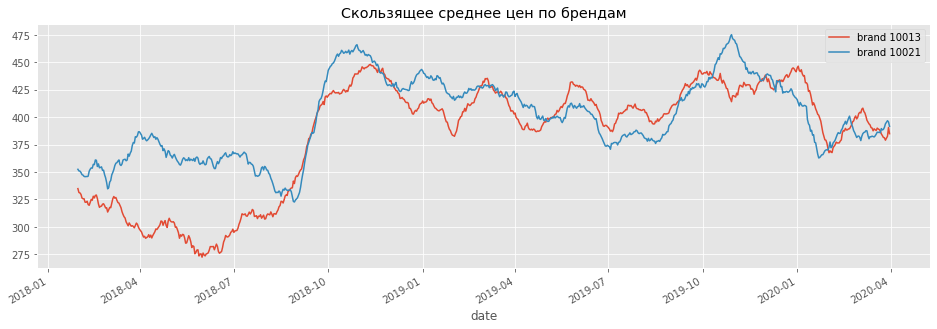

In [188]:
plt.figure(figsize = (16,5))
for brand in brands:
  sales[sales.brand_id == brand].groupby('date')['item_price'].mean().rolling(30).mean().plot(label = 'brand {}'.format(brand))

plt.title('Скользящее среднее цен по брендам')
plt.legend();

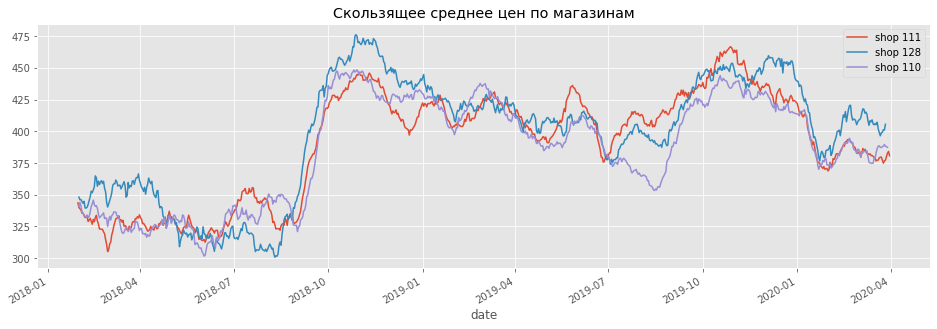

In [189]:
plt.figure(figsize = (16,5))
for shop in shops:
  sales[sales.shop_id == shop].groupby('date')['item_price'].mean().rolling(30).mean().plot(label = 'shop {}'.format(shop))

plt.title('Скользящее среднее цен по магазинам')
plt.legend();

### Категории

In [255]:
sales_m_items = sales.merge(items, how = 'left', on = 'item_id')
categories = sales_m_items.item_category.unique()

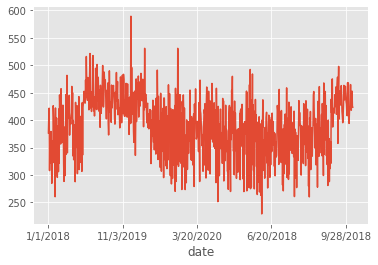

In [260]:
sales_m_items.groupby('date')['item_price'].mean().plot()

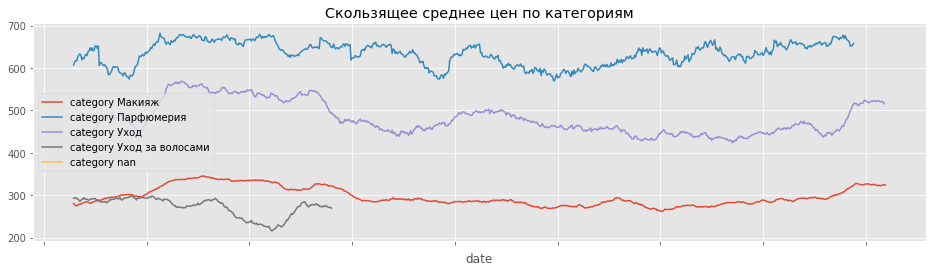

In [257]:
plt.figure(figsize = (16,4))
for category in categories:
  sales_m_items[sales_m_items.item_category == category].groupby('date')['item_price'].mean().rolling(30).mean().plot(label = 'category {}'.format(category))

plt.title('Скользящее среднее цен по категориям')
plt.legend();

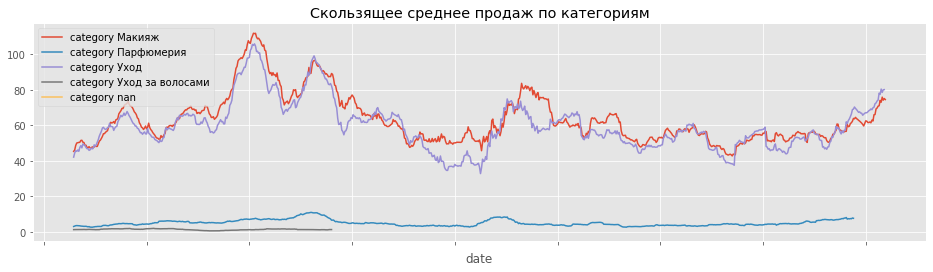

In [250]:
plt.figure(figsize = (16,4))
for category in categories:
  sales_m_items[sales_m_items.item_category == category].groupby('date')['item_cnt_day'].sum().rolling(30).mean().plot(label = 'category {}'.format(category))

plt.title('Скользящее среднее продаж по категориям')
plt.legend();

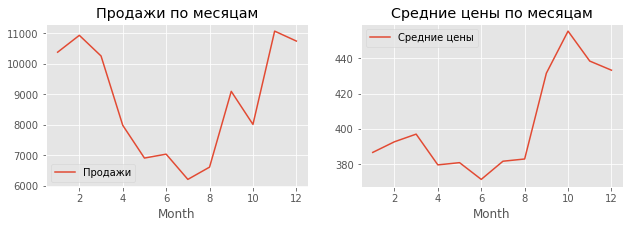

In [280]:
plt.figure(figsize = (16,3))

plt.subplot(1,3,1)
sales.groupby('Month')['item_cnt_day'].sum().plot(label = 'Продажи')
plt.legend()
plt.title('Продажи по месяцам');

plt.subplot(1,3,2)
sales.groupby('Month')['item_price'].mean().plot(label = 'Средние цены')
plt.legend()
plt.title('Средние цены по месяцам');

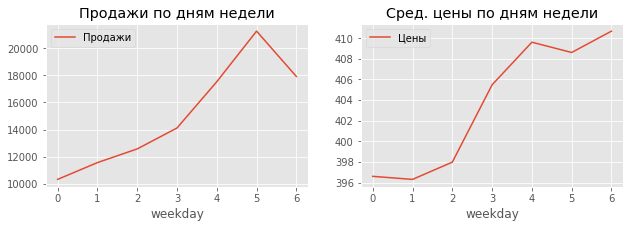

In [279]:
plt.figure(figsize = (16,3))

plt.subplot(1,3,1)
sales.groupby('weekday')['item_cnt_day'].sum().plot(label = 'Продажи')
plt.legend()
plt.title('Продажи по дням недели');

plt.subplot(1,3,2)
sales.groupby('weekday')['item_price'].mean().plot(label = 'Цены')
plt.legend()
plt.title('Сред. цены по дням недели');

По дням недели и месяцам также видны закономерности, которые должна найти модель

### 2. Генерация признаков

Часть признаков уже была сформирована ранее в календаре.
Теперь необходимо сгенерировать признаки, касающиеся продаж и и средних цен

Очевидно, что в общем уровне цен и общем объеме продаж есть полезная информация. Использую это для генерации календарных признаков. В идеале стоит добавить:
- скользящие средние по продажам
- скользящие средние по средним ценам
- все на каждый день - за 7 / 14 / 30 дней. 60 и более нельзя, иначе потеряются зависимости марта 2018, т.к. придется откидывать из обучения первые 2 месяца, по которым можно обучить март
- для каждого бренда, для каждого магазина и каждой категории

Ввиду ограниченности времени сейчас добавлю только скользящие средние по всем продажам и ценам

Также добавлю производные признаки от отдельных пар продукт-магазин:
- скользящие средние по продажам и ценам
- 7ми дневные лаги по этим скользящим средним

In [394]:
for window in [7,14,30]:
    calendar['sales_rol_{}'.format(window)] = sales.groupby('date')['item_cnt_day'].sum().rolling(window).mean()
    calendar['prices_rol_{}'.format(window)] = sales.groupby('date')['item_price'].mean().rolling(window).mean()

In [395]:
calendar

,Month,Year,date_block_num,week,day,day_of_week,day_of_year,holidays,sales_rol_7,prices_rol_7,sales_rol_14,prices_rol_14,sales_rol_30,prices_rol_30
date,,,,,,,,,,,,,,
2018-01-01,1,2018,0,1,1,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,1,2018,0,1,2,1,2,1,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,1,2018,0,1,3,2,3,1,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,1,2018,0,1,4,3,4,1,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,1,2018,0,1,5,4,5,1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-26,3,2020,26,119,816,3,86,0,0.0,385.051919,0.0,389.495911,23.300000,387.937414
2020-03-27,3,2020,26,119,817,4,87,0,0.0,389.634102,0.0,391.901730,19.366667,389.121314
2020-03-29,3,2020,26,119,818,6,89,1,0.0,401.223846,0.0,397.387226,15.033333,391.929738


перепишем функцию, добавив генерацию признаков

In [539]:
def get_tseries(shop_id, item_id):
    
    # сгруппируем и преобразуем данные так, чтобы на каждый день была не более, чем одна запись

    item_cnt_day = sales[(sales.item_id == item_id) & (sales.shop_id == shop_id)]\
            .groupby(['date', 'shop_id', 'item_id', 'brand_id'])[['item_cnt_day']].agg(['sum'])

    if len(item_cnt_day) == 0:
        return None

    item_cnt_day = item_cnt_day.reset_index()
    item_cnt_day.columns = ['date','shop_id','item_id','brand_id','item_cnt_day']
    item_cnt_day.index = item_cnt_day.date
    item_cnt_day.drop('date', axis =1, inplace = True)

    price = sales[(sales.item_id == item_id) & (sales.shop_id == shop_id)].groupby(['date'])\
            [['item_price', 'discamount', 'promo_time']].agg(['mean'])
    price.columns = ['item_price', 'discamount', 'promo_time']

    promo_binary = sales[(sales.item_id == item_id) & (sales.shop_id == shop_id)].groupby(['date'])\
            [['promo', 'spec_promo', 'size_disc']].agg(['mean'])
    promo_binary.columns = ['promo', 'spec_promo', 'size_disc']
    promo_binary = np.round(promo_binary)

    item_sales = pd.concat([item_cnt_day, price, promo_binary], axis = 1)
    # item_sales['size_disc'] = list(map(int, item_sales.discamount/item_sales.item_price*100))

    brand_id = item_cnt_day.brand_id[0]

    # соединяю датафрейм по товару с датафреймом календаря, чтобы получить полноценный временной ряд,
    # со значениями в каждый момент времени за период

    item_sales_ts = calendar.merge(item_sales, how = 'left', on = 'date')
    item_sales_ts.loc[:, 'shop_id'] = shop_id
    item_sales_ts.loc[:, 'item_id'] = item_id
    item_sales_ts.loc[:, 'brand_id'] = brand_id
    item_sales_ts.fillna(0, inplace = True)

    # добавим данные по остаткам на складе

    item_stock = stock_mean[(stock_.itemid == item_id) & (stock_.store == shop_id)]\
                                                            [['date_block_num','days with 0 balance']]
    item_sales_ts = item_sales_ts.merge(item_stock, how = 'left', on = 'date_block_num')
    item_sales_ts.index = calendar.index
    item_sales_ts['days with 0 balance'].fillna(0, inplace = True)

    # добавим производные признаки от продаж конкретного продукта в магазина

    for window in [7,14,30]:
      item_sales_ts['item_sales_rol_{}'.format(window)] = item_sales_ts['item_cnt_day'].rolling(window).mean()
      item_sales_ts['item_prices_rol_{}'.format(window)] = item_sales_ts['item_price'].rolling(window).mean()

    # и 4 7дневных лага по 14 дневным скользящим средним

    for i in range(4):
      item_sales_ts['lag{}_item_sales_rol_14'.format(7*(i+1))] = item_sales_ts['item_sales_rol_14'].shift(7*(i+1))
      item_sales_ts['lag{}_item_prices_rol_14'.format(7*(i+1))] = item_sales_ts['item_prices_rol_14'].shift(7*(i+1))
    
    return item_sales_ts.dropna()

In [397]:
stock_ = get_stock('month_mean')

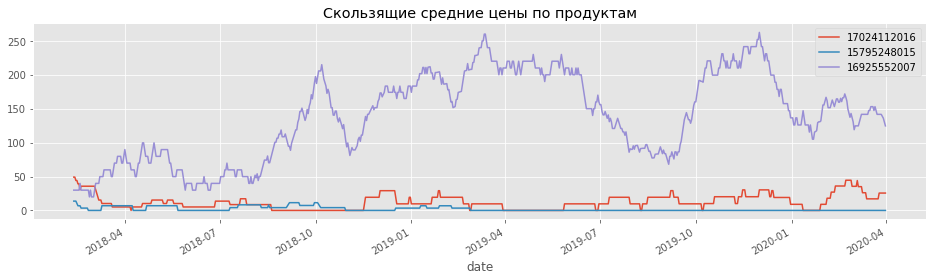

In [490]:
plt.figure(figsize = (16,4))

get_tseries(111, item_ids[0]).item_prices_rol_30.plot(label = item_ids[0])
get_tseries(111, item_ids[1]).item_prices_rol_30.plot(label = item_ids[1])
get_tseries(111, item_ids[2]).item_prices_rol_30.plot(label = item_ids[2])

plt.legend()
plt.title('Скользящие средние цены по продуктам');

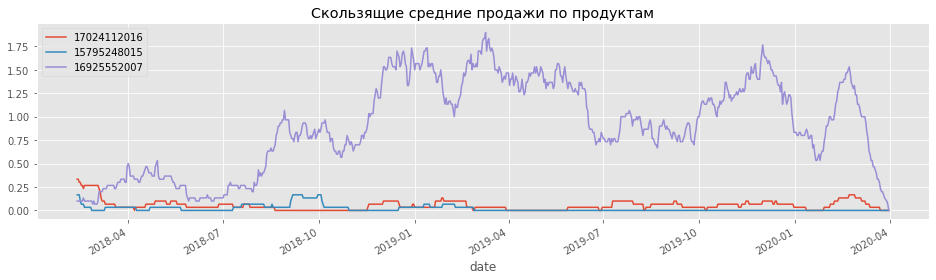

In [491]:
plt.figure(figsize = (16,4))

get_tseries(111, item_ids[0]).item_sales_rol_30.plot(label = item_ids[0])
get_tseries(111, item_ids[1]).item_sales_rol_30.plot(label = item_ids[1])
get_tseries(111, item_ids[2]).item_sales_rol_30.plot(label = item_ids[2])

plt.legend()
plt.title('Скользящие средние продажи по продуктам');

# 3. Валидация. Оценка качества

Как было описано выше, использую RMSE усредненную по всем рядам.

Валидация - простая отложенная выборка: январь 2020.
Возможно использовать полноценную кросс-валидацию, но опять же ввиду отсутствия достаточного времени, возьму простую.

Итоговая оценка качества на данных за февраль 2020.

Для первичного подбора параметров модели использую валидацию на случайно выбранных рядах(10-20 рядов, вместо 3000), чтобы максимально ускорить процесс


In [526]:
VALID = -90
EVAL = -59
FINAL = -30

INDs = sales.groupby(['shop_id', 'item_id'])['item_cnt_day'].sum().index.to_list()

In [535]:
from tqdm.notebook import tqdm
import random

def set_seed(k):
  random.seed(k)
  np.random.seed(k)

from sklearn.metrics import mean_squared_error

посмотрим, какой скор даст примитивная модель, предсказывающая средние продажи за последние 30 дней

In [546]:
%%time
set_seed(40)

tseries = []
rmse = 0

for shop, item in tqdm(INDs):
  tseries.append(get_tseries(shop, item))
  valid = tseries[-1].iloc[VALID: EVAL]
  rmse += mean_squared_error(valid.item_cnt_day, valid.item_sales_rol_30)**0.5

print(rmse/len(tseries))


0.10846046132302511
CPU times: user 4min 33s, sys: 3.02 s, total: 4min 36s
Wall time: 4min 39s


средний скор на валидации по всем рядам:
0.08217828398690405


Теперь оценим, что какие результаты способны дать бустинги на случайно выборке из рядов.
- Зафиксируем seed
- отберем 50 пар магазин-продукт для первичного обучения моделей
- оценим результаты примитивной модели
- обучим CatBoost на каждом ряду
- сравним результаты по скору и времени


In [547]:
!pip install catboost

     |████████████████████████████████| 66.3MB 69kB/s 


In [558]:
import catboost

In [556]:
cat_cols = ['Month', 'Year', 'day_of_week', 'holidays', 'promo_time', 'promo', 'spec_promo']
cols = ['Month', 'Year', 'date_block_num', 'week', 'day', 'day_of_week',
       'day_of_year', 'holidays', 'sales_rol_7', 'prices_rol_7',
       'sales_rol_14', 'prices_rol_14', 'sales_rol_30', 'prices_rol_30','item_price',
       'discamount', 'promo_time', 'promo', 'spec_promo', 'size_disc',
       'days with 0 balance', 'item_sales_rol_7', 'item_prices_rol_7',
       'item_sales_rol_14', 'item_prices_rol_14', 'item_sales_rol_30',
       'item_prices_rol_30', 'lag7_item_sales_rol_14',
       'lag7_item_prices_rol_14', 'lag14_item_sales_rol_14',
       'lag14_item_prices_rol_14', 'lag21_item_sales_rol_14',
       'lag21_item_prices_rol_14', 'lag28_item_sales_rol_14',
       'lag28_item_prices_rol_14']

In [579]:
%%time

set_seed(123456)
random_inds = random.sample(INDs, 50)

tseries = []
rmse = 0

for shop, item in tqdm(random_inds):
  tseries.append(get_tseries(shop, item))
  valid = tseries[-1].iloc[VALID: EVAL]
  rmse += mean_squared_error(valid.item_cnt_day, valid.item_sales_rol_30)**0.5

print(rmse/len(tseries))


0.06869775705058795
CPU times: user 3.73 s, sys: 49.7 ms, total: 3.77 s
Wall time: 3.83 s


Сиды: 123456, 156, 298375, 346346

Скор на валидации 0.13049454838495056, 
0.08758699257078303, 0.08687567555397731, 0.06869775705058795

In [580]:
rmse = 0

for ts in tqdm(tseries):
  train = ts.iloc[:VALID]
  valid = ts.iloc[VALID: EVAL]

  x_train = train[cols]
  y_train = train['item_cnt_day']

  x_valid = valid[cols]
  y_valid = valid['item_cnt_day']
  
  if y_train.sum() == 0:
      continue
  else:
      cat_model = catboost.CatBoostRegressor(n_estimators = 200,
                                                loss_function='RMSE',
                                                verbose = 0)

      cat_model.fit(x_train, y_train)
  rmse += mean_squared_error(cat_model.predict(x_valid), y_valid)**0.5

print(rmse/len(tseries))


0.026339639678122334


Скор catboost: 
0.06663773179074708,
0.026176368952796385, 
0.03120303422437837, 
0.026339639678122334

Средний скор catboost 0.0376 против 0.0934 для примитивной модели

для 50 рядов на 4 сидах catboost дает скор в 3 раза лучше.
Пока что остановимся на данной модели

Обучим и оценим модель на отложенной выборке по всем рядам.
После чего сформируем предсказание на март 2020

In [592]:
%%time

tseries = []
rmse = 0

for shop, item in tqdm(INDs):
  tseries.append(get_tseries(shop, item))
  eval = tseries[-1].iloc[EVAL: FINAL]
  rmse += mean_squared_error(eval.item_cnt_day, eval.item_sales_rol_30)**0.5

print(rmse/len(tseries))


0.10846046132302511
CPU times: user 4min 38s, sys: 3.23 s, total: 4min 41s
Wall time: 4min 44s


Для экономии времени обучаем модели, оцениваем, сохраняем и сразу формируем предсказание

In [598]:
%%time

rmse = 0
prediction_dict = {}

for ts, inds in tqdm(zip(tseries, INDs)):
  train = ts.iloc[:EVAL]
  eval = ts.iloc[EVAL: FINAL]

  x_train = train[cols]
  y_train = train['item_cnt_day']

  x_eval = eval[cols]
  y_eval = eval['item_cnt_day']
  
  if y_train.sum() == 0:
      preds = [0]*len(y_eval)
  else:
      cat_model = catboost.CatBoostRegressor(n_estimators = 200,
                                                loss_function='RMSE',
                                                verbose = 0)

      cat_model.fit(x_train, y_train)
      preds = cat_model.predict(x_eval)
  rmse += mean_squared_error(preds, y_eval)**0.5

  # предиктим и сохраняем февраль и март
  prediction_dict[inds] = cat_model.predict(ts.iloc[EVAL:][cols])

print(rmse/len(tseries))


0.047391167946967995
CPU times: user 1h 1min 3s, sys: 3min 10s, total: 1h 4min 14s
Wall time: 36min 15s


Скор catboost моделей 0.047391167946967995 против примитивного предсказания 0.10846046132302511

In [614]:
submission_table = []

for key, value in prediction_dict.items():
  submission_table.append([26, key[0], key[1], value[FINAL:].sum().round()])

**submission**

In [617]:
submission = pd.DataFrame(submission_table)
submission.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']
submission

,date_block_num,shop_id,item_id,item_cnt_month
0,26,110,7851312001,4.0
1,26,110,7851312002,1.0
2,26,110,7851312003,2.0
3,26,110,7851312009,0.0
4,26,110,7851536002,0.0
...,...,...,...,...
3932,26,128,90036912004,0.0
3933,26,128,90036912007,0.0
3934,26,128,90036912012,5.0
3935,26,128,90036912013,3.0


In [621]:
submission.to_csv(PATH+'/submission.csv', index=False)

**Визуализация результата**

Сравним суммарные продажи по продуктам с прогнозом модели

In [622]:
forecast_table = []

for key, value in prediction_dict.items():
  forecast_table.append(value)

In [632]:
forecast = pd.DataFrame(np.array(forecast_table).sum(axis = 0))
forecast.index = ts.iloc[EVAL:].index

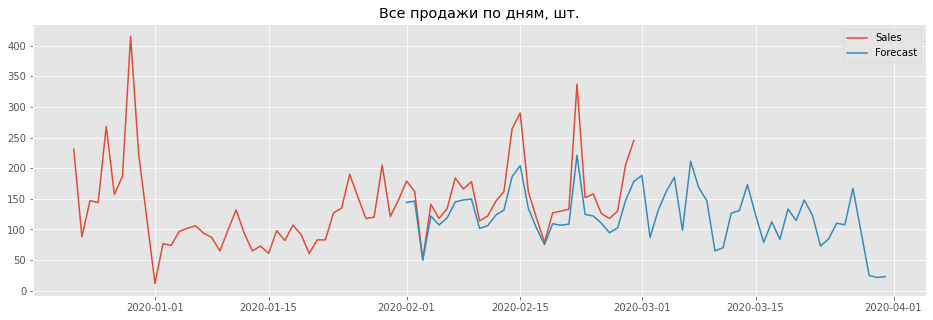

In [643]:
plt.figure(figsize = (16,5))
plt.plot(sales.groupby('date')['item_cnt_day'].sum().iloc[-100:-30], label = 'Sales')
plt.plot(forecast, label = 'Forecast')
plt.legend()
plt.title('Все продажи по дням, шт.');

# Итоги

В данном ноутбуке представлена только базовая модель. 
Логика и последовательность работа описана выше по ходу разработки решения.

Наибольшее внимание было уделено:
- предобработке и очистке данных
- генерации признаков,

...что на первом этапе должно же принести видимый результат.

Также выбрана стратегия валидации и метрика качества - базовая и улучшенная, на перспективу.

При наличии времени возможно значительное улучшение модели за счет:
- тестирования большего числа моделей
- более тщательного подбора гиперпараметров
- внимательному отбору признаков и поиску новых
- использованию метрики WRMSSE
- оптимизации вычислений
- ансамблирования и выравнивания моделей

Судя по поведению метрики в процессе первых тестов, кросс-валидация здесь не обязательна. Это связано с тем, что мы имеем большое количество моделей из одного семейства (построенных на выборках полученных из одного распределения). 
Однако из-за особенностей данных(разрежены, что может повлечь высокую дисперсию в решениях) можно заподозрить, что большего можно добиться за счет усреднения нескольких моделей по сидам.